## 1. OLS Regression Model for Fair Value Estimation (Baseline Strategy)

In [11]:
OLS_model = LinearRegression(fit_intercept=True)
raw_1 = df_target_features.copy()
raw_1.reset_index(inplace=True)
raw_1['datadate'] = raw_1['datadate'].astype('str')
X = raw_1.drop('Market_Cap', axis=1)
y = raw_1[['cusip', 'datadate', 'Market_Cap']]
df_OLS_Quintile_Signal = pd.DataFrame(index=list_company)
df_OLS_Decile_Signal = pd.DataFrame(index=list_company)
df_OLS_20_Divided_Signal = pd.DataFrame(index=list_company)
df_OLS_Percentile_Signal = pd.DataFrame(index=list_company)

for i in date_list:
    X_train = X[X.datadate == i]
    X_train = X_train.iloc[:, 2:]
    y_temp = y[y.datadate == i]
    y_train = y_temp.iloc[:, 2]

    OLS_fit = OLS_model.fit(X_train, y_train)
    y_fair = OLS_fit.predict(X_train)
    y_fair = pd.DataFrame(y_fair, columns=['Fair_Value'])
    y_final = pd.concat([y_temp.reset_index(), y_fair], axis=1)
    y_final.set_index('cusip', inplace=True)
    y_final['Mispricing_Signal'] = (y_final['Fair_Value'] - y_final['Market_Cap']) / y_final['Market_Cap']
    y_final['Quintile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 5, labels=False)
    y_final['Quintile_Rank'].replace(quintile_rank, quintile_position, inplace=True)
    y_final['Decile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 10, labels=False)
    y_final['Decile_Rank'].replace(decile_rank, decile_position, inplace=True)
    y_final['20ths_divided_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 20, labels=False)
    y_final['20ths_divided_Rank'].replace(twenths_rank, twenths_position, inplace=True)
    y_final['Percentile_Rank'] = pd.qcut(y_final['Mispricing_Signal'], 100, labels=False)
    y_final['Percentile_Rank'].replace(percentile_rank, percentile_position, inplace=True)
    df_OLS_Quintile_Signal = df_OLS_Quintile_Signal.join(y_final['Quintile_Rank'].rename(i), how='left')
    df_OLS_Decile_Signal = df_OLS_Decile_Signal.join(y_final['Decile_Rank'].rename(i), how='left')
    df_OLS_20_Divided_Signal = df_OLS_20_Divided_Signal.join(y_final['20ths_divided_Rank'].rename(i), how='left')
    df_OLS_Percentile_Signal = df_OLS_Percentile_Signal.join(y_final['Percentile_Rank'].rename(i), how='left')

### (1) Performance Analysis

In [12]:
df_202206 = pd.DataFrame(columns=['2022-06'], index=list_company)
df_OLS_Decile_Signal = pd.concat([df_OLS_Decile_Signal, df_202206], axis=1)
df_OLS_Decile_Signal = df_OLS_Decile_Signal.fillna(0).T
df_OLS_Decile_Signal = df_OLS_Decile_Signal.shift(1).dropna()

df_OLS_Quintile_Signal = pd.concat([df_OLS_Quintile_Signal, df_202206], axis=1)
df_OLS_Quintile_Signal = df_OLS_Quintile_Signal.fillna(0).T
df_OLS_Quintile_Signal = df_OLS_Quintile_Signal.shift(1).dropna()

df_OLS_20_Divided_Signal = pd.concat([df_OLS_20_Divided_Signal, df_202206], axis=1)
df_OLS_20_Divided_Signal = df_OLS_20_Divided_Signal.fillna(0).T
df_OLS_20_Divided_Signal = df_OLS_20_Divided_Signal.shift(1).dropna()

df_OLS_Percentile_Signal = pd.concat([df_OLS_Percentile_Signal, df_202206], axis=1)
df_OLS_Percentile_Signal = df_OLS_Percentile_Signal.fillna(0).T
df_OLS_Percentile_Signal = df_OLS_Percentile_Signal.shift(1).dropna()

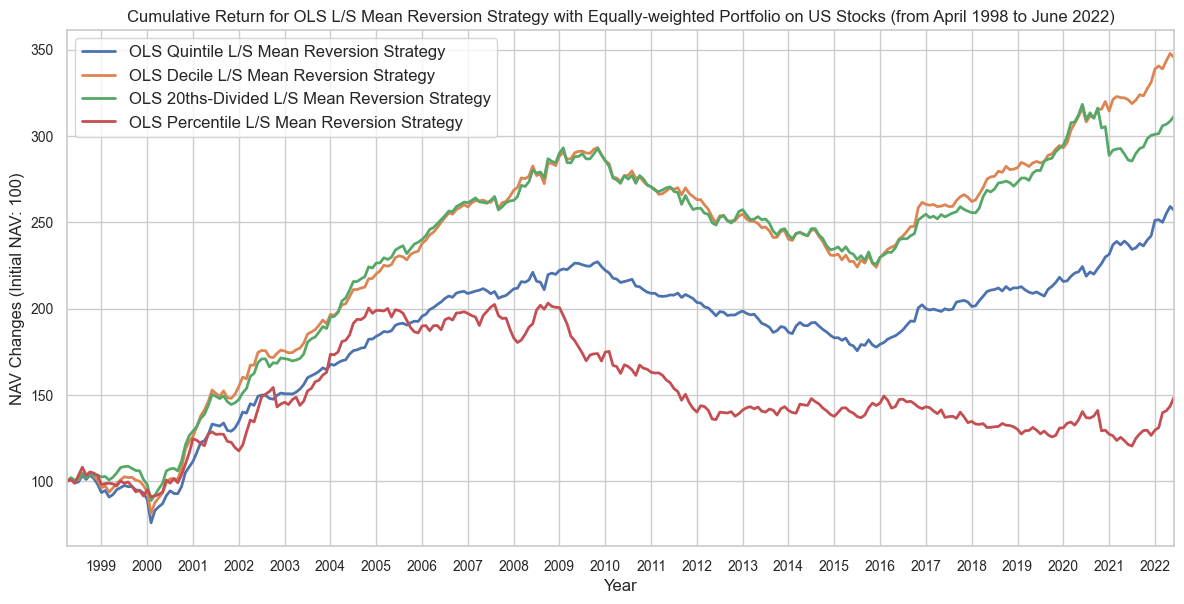

In [13]:
cum_OLS_Q_strategy_return = get_price_df(df_OLS_Quintile_Signal, df_returns, nav=100, model_type=None)
cum_OLS_D_strategy_return = get_price_df(df_OLS_Decile_Signal, df_returns, nav=100, model_type=None)
cum_OLS_T_strategy_return = get_price_df(df_OLS_20_Divided_Signal, df_returns, nav=100, model_type=None)
cum_OLS_P_strategy_return = get_price_df(df_OLS_Percentile_Signal, df_returns, nav=100, model_type=None)

cum_OLS_strategy_return = pd.concat([cum_OLS_Q_strategy_return.rename('OLS Quintile L/S Mean Reversion Strategy'),
                                     cum_OLS_D_strategy_return.rename('OLS Decile L/S Mean Reversion Strategy'),
                                     cum_OLS_T_strategy_return.rename('OLS 20ths-Divided L/S Mean Reversion Strategy'),
                                     cum_OLS_P_strategy_return.rename('OLS Percentile L/S Mean Reversion Strategy')], axis=1)

ax = cum_OLS_strategy_return.plot(grid=True, figsize=(12, 6), fontsize=10, linewidth=2)
plt.legend(fontsize=12, loc='upper left')
plt.ylabel('NAV Changes (Initial NAV: 100)', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.xticks(x, x)
plt.tight_layout()
plt.title('Cumulative Return for OLS L/S Mean Reversion Strategy with Equally-weighted Portfolio on US Stocks (from April 1998 to June 2022)', fontsize=12)
plt.show()

In [14]:
# Performance Stats
stats_OLS_Q = get_performance_stats(cum_OLS_Q_strategy_return, rfr=risk_free_rate_df, label='OLS Quintile (Initial NAV: 100)')
stats_OLS_D = get_performance_stats(cum_OLS_D_strategy_return, rfr=risk_free_rate_df, label='OLS Decile (Initial NAV: 100)')
stats_OLS_T = get_performance_stats(cum_OLS_T_strategy_return, rfr=risk_free_rate_df, label='OLS 20ths (Initial NAV: 100)')
stats_OLS_P = get_performance_stats(cum_OLS_P_strategy_return, rfr=risk_free_rate_df, label='OLS Percentile (Initial NAV: 100)')
OLS_stats = pd.concat([stats_OLS_Q, stats_OLS_D, stats_OLS_T, stats_OLS_P], axis=0)
display(OLS_stats)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
OLS Quintile (Initial NAV: 100),1.569753,0.039687,0.018682,0.064070,0.327844,-1.192248,19.417478,259.092453,2022-05-31,0.226965,2009-11-30,2015-07-31,2020-12-31,4049
OLS Decile (Initial NAV: 100),2.454319,0.052448,0.018682,0.065299,0.517086,-0.399121,12.497734,347.718923,2022-05-31,0.236413,2009-11-30,2015-12-31,2019-12-31,3683
OLS 20ths (Initial NAV: 100),2.114006,0.047956,0.018682,0.059712,0.490246,-0.096700,5.821567,318.267009,2020-06-30,0.230194,2009-02-28,2015-12-31,2020-01-31,3989
OLS Percentile (Initial NAV: 100),0.486381,0.016478,0.018682,0.078997,-0.027901,0.333537,1.253495,203.130571,2008-10-31,0.407537,2008-10-31,2021-07-31,Yet to recover,Yet to recover


In [15]:
stats2_OLS_Q = get_performance_stats_2(df_OLS_Quintile_Signal, df_returns, df_market_cap, label='OLS Quintile')
stats2_OLS_D = get_performance_stats_2(df_OLS_Decile_Signal, df_returns, df_market_cap, label='OLS Decile')
stats2_OLS_T = get_performance_stats_2(df_OLS_20_Divided_Signal, df_returns, df_market_cap, label='OLS 20ths')
stats2_OLS_P = get_performance_stats_2(df_OLS_Percentile_Signal, df_returns, df_market_cap, label='OLS Percentile')
OLS_stats2 = pd.concat([stats2_OLS_Q, stats2_OLS_D, stats2_OLS_T, stats2_OLS_P], axis=0)
display(OLS_stats2)

,Total Return,Avg Monthly Return,Avg Mkt Cap,Fraction>0,+ Return Stocks (Avg),- Return Stocks (Avg),Odds Ratio,Odds Ratio 98-10,Odds Ratio 11-22,Transactions/Month
OLS Quintile (Long & Short),1.569753,0.003249,2.414526e+10,0.589655,0.088443,-0.084851,0.507730,0.516702,0.499842,394.696552
(Long Position),252.160063,0.019199,4.008645e+09,0.679310,0.088877,-0.068285,0.563920,0.576472,0.553001,208.972414
(Short Position),-0.987987,-0.015080,4.301742e+10,0.344828,0.073872,-0.087602,0.453250,0.459396,0.447790,206.972414
OLS Decile (Long & Short),2.454319,0.004269,2.848441e+10,0.620690,0.089126,-0.084937,0.512453,0.524860,0.501570,253.589655
(Long Position),616.954315,0.022330,3.197428e+09,0.703448,0.089689,-0.064551,0.574147,0.594294,0.556750,134.410345
(Short Position),-0.991299,-0.016171,5.116239e+10,0.355172,0.074000,-0.089825,0.453156,0.459218,0.447757,127.610345
OLS 20ths (Long & Short),2.114006,0.003911,3.022323e+10,0.624138,0.089644,-0.086998,0.515369,0.527438,0.504818,146.100000
(Long Position),1082.445255,0.024304,2.831480e+09,0.727586,0.090713,-0.062709,0.584266,0.607506,0.564419,79.386207
(Short Position),-0.996221,-0.018987,5.322709e+10,0.331034,0.073576,-0.093097,0.449376,0.452593,0.446501,70.544828
OLS Percentile (Long & Short),0.486381,0.001363,6.755169e+09,0.496552,0.089302,-0.090928,0.512237,0.524882,0.501197,32.562069


In [49]:
cum_OLS_Q_strategy_return_L = get_price_df(df_OLS_Quintile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_OLS_Q_strategy_return_S = get_price_df(df_OLS_Quintile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)
cum_OLS_D_strategy_return_L = get_price_df(df_OLS_Decile_Signal.replace(-1, 0), df_returns, nav=100, model_type=None)
cum_OLS_D_strategy_return_S = get_price_df(df_OLS_Decile_Signal.replace([1, -1], [0, 1]), df_returns, nav=100, model_type=None)

stats_OLS_Q_L = get_performance_stats(cum_OLS_Q_strategy_return_L, rfr=risk_free_rate_df, label='OLS Quintile L (Initial NAV: 100)')
stats_OLS_Q_S = get_performance_stats(cum_OLS_Q_strategy_return_S, rfr=risk_free_rate_df, label='OLS Quintile S (Initial NAV: 100)')
stats_OLS_D_L = get_performance_stats(cum_OLS_D_strategy_return_L, rfr=risk_free_rate_df, label='OLS Decile L (Initial NAV: 100)')
stats_OLS_D_S = get_performance_stats(cum_OLS_D_strategy_return_S, rfr=risk_free_rate_df, label='OLS Decile S (Initial NAV: 100)')
OLS_stats3 = pd.concat([stats_OLS_Q_L, stats_OLS_Q_S, stats_OLS_D_L, stats_OLS_D_S], axis=0)
display(OLS_stats3)

,Total Return,Avg Return,Rf Rate,Volatility,Sharpe Ratio,Skewness,Kurtosis,HWM,HWM date,MDD,Peak Date,Trough Date,Recession Date,MDD Duration
OLS Quintile L (Initial NAV: 100),252.160063,0.256345,0.018682,0.169670,1.400739,0.144182,0.668091,28715.797987,2022-03-31,0.118394,2022-03-31,2022-06-30,Yet to recover,Yet to recover
OLS Quintile S (Initial NAV: 100),31.105965,0.153791,0.018682,0.192377,0.702311,-0.042414,2.443749,4269.985998,2021-10-31,0.248101,2021-10-31,2022-06-30,Yet to recover,Yet to recover
OLS Decile L (Initial NAV: 100),616.954315,0.303440,0.018682,0.171812,1.657374,0.233255,0.922881,70949.242297,2022-03-31,0.129019,2022-03-31,2022-06-30,Yet to recover,Yet to recover
OLS Decile S (Initial NAV: 100),43.043421,0.168931,0.018682,0.192210,0.781691,-0.209238,1.847218,5445.832565,2021-10-31,0.191245,2021-10-31,2022-06-30,Yet to recover,Yet to recover


### (2) Feature Importance

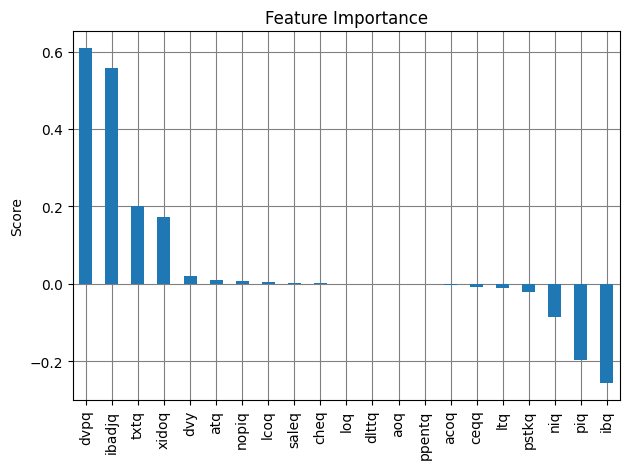

In [245]:
OLS_importances = OLS_model.coef_
OLS_importances_1 = pd.Series(OLS_importances, index=feature_names).sort_values(ascending=False)
ols_f = OLS_importances_1 / OLS_importances_1.sum()

fig, ax1 = plt.subplots()
ols_f.plot.bar(ax=ax1)
ax1.set_axisbelow(True)
ax1.grid(color='gray')
ax1.set_title('Feature Importance')
ax1.set_ylabel('Score')
fig.tight_layout()
plt.show()